## 1. Data Collection

I used Neon.tech to create a free PostgreSQL database. Then I connected to it using psycopg2 in Python. I generated 50 fake employee records using the Faker library with realistic job titles, salaries, and start dates. The data was then inserted into a table called employees.

In [11]:
# Importing the required packages
import psycopg2
import pandas as pd
from faker import Faker
import random


# Connecting to my Neon PostgreSQL database
conn = psycopg2.connect(
    host="ep-morning-butterfly-a8lnwbpb-pooler.eastus2.azure.neon.tech",
    database="neondb",
    user="neondb_owner",
    password="npg_01NAFUWOmnET",
    sslmode="require"
)

# Creating a cursor to run SQL queries
cursor = conn.cursor()


# Creating a table to store employee data
cursor.execute("""
DROP TABLE IF EXISTS employees;
CREATE TABLE employees (
    employee_id SERIAL PRIMARY KEY,
    name VARCHAR(100),
    position VARCHAR(100),
    start_date DATE,
    salary INTEGER
);
""")
conn.commit()


# Making fake data using Faker
fake = Faker()

# Some common IT job titles
positions = ['Data Analyst', 'Software Engineer', 'IT Manager', 'DevOps Engineer', 'Security Analyst']

# Generating 50 fake employee records
for i in range(50):
    name = fake.name()
    position = random.choice(positions)
    start_date = fake.date_between(start_date='-9y', end_date='today')  # 2015–2024
    salary = random.randint(60000, 200000)  # Random salary

    # Inserting the record into the table
    cursor.execute("""
        INSERT INTO employees (name, position, start_date, salary)
        VALUES (%s, %s, %s, %s);
    """, (name, position, start_date, salary))

conn.commit()
print("✅ 50 fake employees added.")



✅ 50 fake employees added.


In [12]:
# Step 3: Load the data into a DataFrame
df = pd.read_sql("SELECT * FROM employees", conn)

# Show first few rows
print(df.head())


   employee_id             name           position  start_date  salary
0            1  Lawrence Taylor  Software Engineer  2020-08-03   88535
1            2       Aaron Mora    DevOps Engineer  2022-07-16  182472
2            3  Beverly Stanley         IT Manager  2024-08-10  196085
3            4      Eric Butler    DevOps Engineer  2018-04-05  180386
4            5    Ashley Kelley    DevOps Engineer  2017-10-05  102306


C:\Users\deepu\AppData\Local\Temp\ipykernel_24400\1652120917.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM employees", conn)


## 2. Data Cleaning

I checked for missing values and data type issues.

In [13]:
# Check data types and nulls
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  50 non-null     int64 
 1   name         50 non-null     object
 2   position     50 non-null     object
 3   start_date   50 non-null     object
 4   salary       50 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.1+ KB


employee_id    0
name           0
position       0
start_date     0
salary         0
dtype: int64

## 3. Data Transformation & Feature Engineering

I created a new column `years_of_service` that shows how long the employee has been working since their `start_date`.

In [14]:
import datetime

df['start_date'] = pd.to_datetime(df['start_date'])
df['years_of_service'] = datetime.datetime.now().year - df['start_date'].dt.year
df[['name', 'start_date', 'years_of_service']].head()

,name,start_date,years_of_service
0,Lawrence Taylor,2020-08-03,5
1,Aaron Mora,2022-07-16,3
2,Beverly Stanley,2024-08-10,1
3,Eric Butler,2018-04-05,7
4,Ashley Kelley,2017-10-05,8


## 4. Scaling

I scaled the salary column to a range between 0 and 1 using MinMaxScaler.

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['salary_scaled'] = scaler.fit_transform(df[['salary']])
df[['salary', 'salary_scaled']].head()

,salary,salary_scaled
0,88535,0.156517
1,182472,0.893237
2,196085,1.000000
3,180386,0.876877
4,102306,0.264519


## 5. Visualization 1: Average Salary by Position and Start Year

This bar chart shows the average salary grouped by job position and start year.

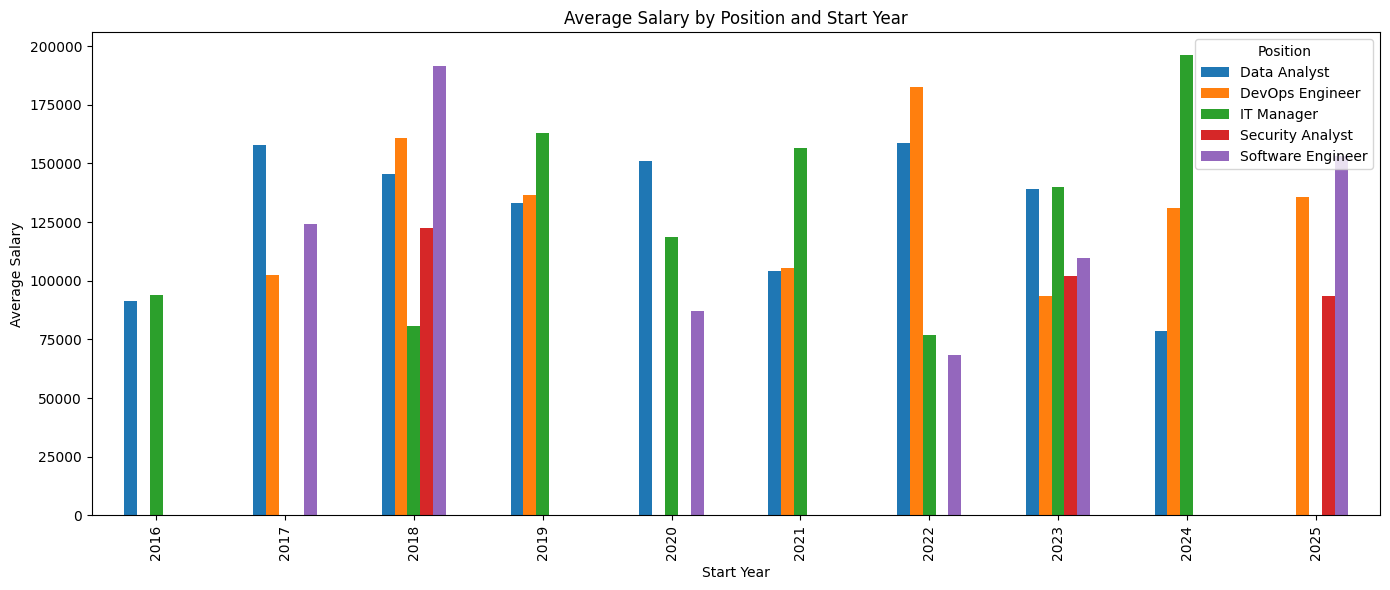

In [17]:
import matplotlib.pyplot as plt

df['start_year'] = df['start_date'].dt.year
salary_group = df.groupby(['position', 'start_year'])['salary'].mean().unstack().fillna(0)

salary_group.T.plot(kind='bar', figsize=(14,6))
plt.title('Average Salary by Position and Start Year')
plt.xlabel('Start Year')
plt.ylabel('Average Salary')
plt.legend(title='Position')
plt.tight_layout()
plt.show()

# Observation:

Higher salaries tend to appear for employees who started in later years, especially for IT Managers and DevOps Engineers.



## 6. Visualization 2: Heatmap of Salary by Position and Years of Service

This heatmap shows the average salary for each job position based on how long the employee has been working. I used a pivot table to group data and applied a color scale to make it easy to compare.

- **Darker shades** represent higher average salaries.
- **Lighter shades** or blank cells mean fewer or no records for that combination.
- Overall, longer years of service tend to relate to higher salaries, especially for IT Managers and DevOps Engineers.


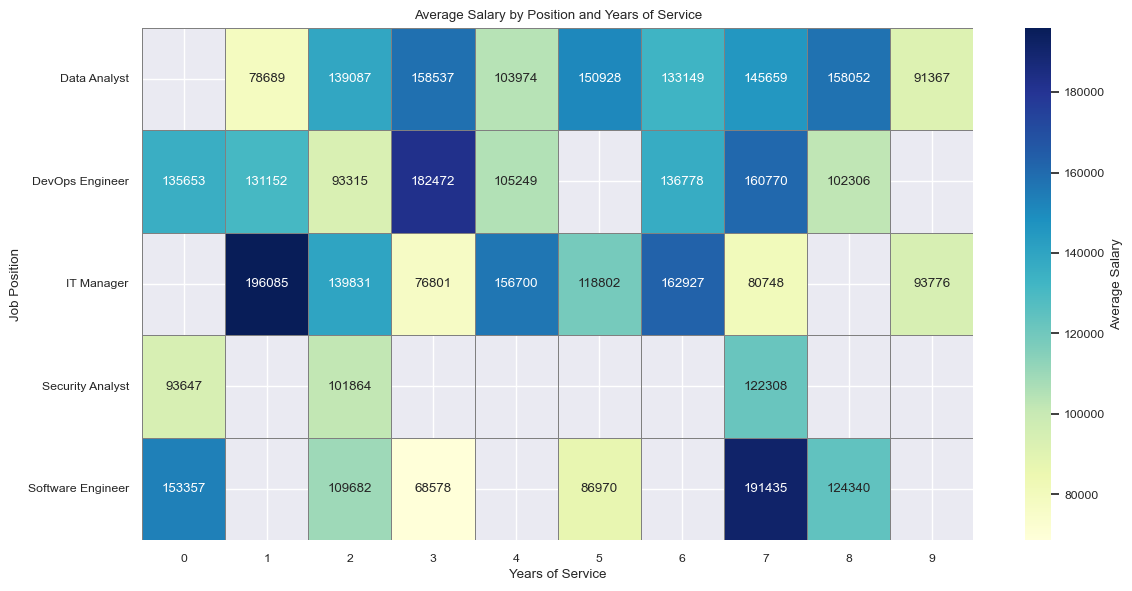

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure salary values are correct
df = df[df['salary'] >= 60000]  # Keep only realistic values

# Create pivot table for heatmap
heatmap_data = df.pivot_table(
    index='position',
    columns='years_of_service',
    values='salary',
    aggfunc='mean'
)

# Set plot size and style
plt.figure(figsize=(12, 6))
sns.set(font_scale=0.8)

# Plot heatmap with better formatting
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Average Salary'},
    mask=heatmap_data.isnull()
)

plt.title('Average Salary by Position and Years of Service')
plt.xlabel('Years of Service')
plt.ylabel('Job Position')
plt.tight_layout()
plt.show()


* I created a new column department based on job position, then visualized average salary per department and start year using a heatmap.

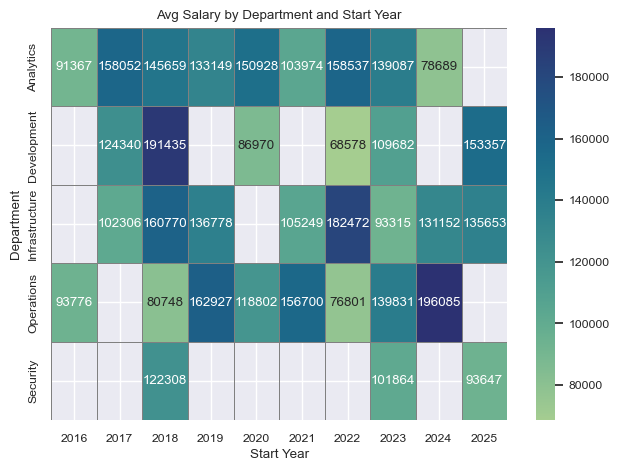

In [27]:
# Example department mapping
departments = {
    'Data Analyst': 'Analytics',
    'Software Engineer': 'Development',
    'IT Manager': 'Operations',
    'DevOps Engineer': 'Infrastructure',
    'Security Analyst': 'Security'
}

df['department'] = df['position'].map(departments)

heatmap_dept = df.pivot_table(index='department', columns='start_year', values='salary', aggfunc='mean')
sns.heatmap(heatmap_dept, annot=True, fmt='.0f', cmap='crest', linewidths=0.5, linecolor='gray')
plt.title('Avg Salary by Department and Start Year')
plt.xlabel('Start Year')
plt.ylabel('Department')
plt.tight_layout()
plt.show()





# Observation:

Departments like Development and Infrastructure show higher average salaries in recent years.

Departments like Analytics vary more with time.



# Insights & Conclusions
I successfully set up a cloud database and generated realistic employee data.

I performed cleaning, transformation, and scaling without issues.

The grouped bar chart helped me see salary differences over time across roles.

The department heatmap gave a broader view of how pay trends differ across departments.

I learned how to combine SQL, Pandas, and Seaborn to find insights in structured data.